## Practical 9
### Exercises

1. Initialise a small version of your transformer model (do not use more than 4 layers and 64 hidden units unless you have access to sufficient compute).
2. Initialise the dataloader using the dataset class from practical 5.
3. Initialise the loss function (cross-entropy loss) optimiser and learning rate scheduler.
4. Implement the training loop.
5. Train the model for 5 epochs and ensure that loss decreases for both the training and validation sets of the dataset. You can use a small randomly selected subset of the training data to speed up training. 

In [5]:
import torch
import json
import random
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader, Subset
from tqdm import tqdm
# use realtive import
import sys
sys.path.append('..')

from modelling.model import Transformer
from modelling.dataloader import TranslationDataset, MyBPETokenizer
from modelling.optimizer import create_adamw_optimizer
from modelling.scheduler import TransformerScheduler

In [6]:
# load the data
print("Loading data...")
with open("../data/cleaned_wmt17_de_en_split_train.json", encoding='utf-8') as f:
    train_data = json.load(f)
    
with open("../data/cleaned_wmt17_de_en_split_validation.json", "r", encoding="utf-8") as f:
    val_data = json.load(f)

with open("../data/cleaned_wmt17_de_en_texts_for_tokenizer.json", "r", encoding="utf-8") as f:
    tokenizer_texts = json.load(f)

print(f"Train samples: {len(train_data)}")
print(f"Val samples: {len(val_data)}")

Loading data...
Train samples: 4801360
Val samples: 2782


In [7]:
# use small subset for training on CPU for 5 epochs
# increased the number of samples because of overfitting with too small data
num_train_samples = 20000
num_val_samples = 2000

random.seed(1234)

# randomly sample the training and validation data
train_data = random.sample(train_data, num_train_samples)
val_data = random.sample(val_data, num_val_samples)

tokenizer_texts = random.sample(tokenizer_texts, 50000)

print(f"Using {len(train_data)} training samples and {len(val_data)} validation samples.")

Using 20000 training samples and 2000 validation samples.


In [8]:
# train Tokenizer
tokenizer = MyBPETokenizer(texts=tokenizer_texts, vocab_size=5000, save_dir="../data/small_bpe_tokenizer")

Loading existing tokenizer from ../data/small_bpe_tokenizer


In [9]:
# instanciate dataset and dataloader
train_dataset = TranslationDataset(train_data, tokenizer, max_src_len=32, max_tgt_len=32)
val_dataset = TranslationDataset(val_data, tokenizer, max_src_len=32, max_tgt_len=32)

train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=False)

print("Datasets and Dataloaders initialized.")
print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")

Datasets and Dataloaders initialized.
Train dataset size: 20000
Validation dataset size: 2000


In [10]:
# initialize model
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda:1


In [11]:
model_postln = Transformer(
    vocab_size=5000,
    d_model=64,
    n_heads=4,
    num_encoder_layers=2,
    num_decoder_layers=2,
    max_len=64,
    dim_feedforward=256,
    dropout=0.1,
).to(device)

In [12]:
from modelling.transformer_preln import PreLNTransformer

In [13]:
model_preln = PreLNTransformer(
    vocab_size=5000,
    d_model=64,
    n_heads=4,
    num_encoder_layers=2,
    num_decoder_layers=2,
    max_len=64,
    dim_feedforward=256,
    dropout=0.1,
).to(device)

In [14]:
# count parameters
total_params = sum(p.numel() for p in model_postln.parameters() if p.requires_grad)
print(f"Total trainable parameters: {total_params}")

Total trainable parameters: 876936


In [15]:
# setup training
criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_id)

# added weight decay for better generalization
optimizer = create_adamw_optimizer(model_postln, learning_rate=1e-4, weight_decay=1e-4)
scheduler = TransformerScheduler(optimizer, d_model=64, warmup_steps=100)

In [16]:
def train_epoch(model, dataloader, criterion, optimizer, scheduler, device, epoch_num):
    model.train()
    total_loss = 0
    batch_count = 0
    
    for batch_idx, batch in enumerate(tqdm(dataloader, desc=f"Training Epoch {epoch_num}")):
        src_ids = batch['src_ids'].to(device)
        tgt_ids = batch['tgt_ids'].to(device)

        tgt_input = tgt_ids[:, :-1] # remove last token for decoder input
        tgt_output = tgt_ids[:, 1:] # remove first token for target output
        
        #if batch_idx == 0 and epoch_num % 1 == 0:
        #    print(f"Batch {batch_idx} shapes")
        #    print(f"src_ids: {src_ids.shape}")
        #    print(f"tgt_ids: {tgt_ids.shape}")
        
        #if batch_idx == 0 and epoch_num % 1 == 0:
        #    print(f"tgt_input: {tgt_input.shape}")
        #    print(f"tgt_output: {tgt_output.shape}")
        
        # create padding masks
        src_mask = (src_ids != tokenizer.pad_id).to(device)  # [batch_size, src_len]
        tgt_mask = (tgt_input != tokenizer.pad_id).to(device)  # [batch_size, tgt_len]
        memory_mask = src_mask  # [batch_size, src_len]
        
        # Forward pass
        optimizer.zero_grad()
        output = model(src_ids, tgt_input,
                       src_mask=src_mask,
                       tgt_mask=tgt_mask,
                       memory_mask=memory_mask)
        
        #if batch_idx == 0 and epoch_num % 1 == 0:
        #    print(f"Model output shape: {output.shape}")

        # Reshape for loss calculation
        # CrossEntropyLoss expects: input=[N, C], target=[N]
        # where N = batch_size * seq_len, C = vocab_size
        batch_size, seq_len, vocab_size = output.shape
        output_reshaped = output.reshape(-1, vocab_size)      # [batch_size * seq_len, vocab_size]
        tgt_output_reshaped = tgt_output.reshape(-1)          # [batch_size * seq_len]
        
        #if batch_idx == 0:
        #    print(f"\nAfter reshaping for loss:")
        #    print(f"output_reshaped shape: {output_reshaped.shape}")           # [batch*seq, vocab]
        #    print(f"tgt_output_reshaped shape: {tgt_output_reshaped.shape}")   # [batch*seq]
        #    print(f"vocab_size: {vocab_size}")
        #print(f"Output reshaped shape: {output_reshaped.shape}, Target reshaped shape: {tgt_output_reshaped.shape}, Vocab size: {vocab_size}")
        loss = criterion(output_reshaped, tgt_output_reshaped)
        
        # backward pass and optimization
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        total_loss += loss.item()
        batch_count += 1
    
    avg_loss = total_loss / batch_count
    return avg_loss

In [17]:
def validate(model, dataloader, criterion, device, epoch_num):
    model.eval()
    total_loss = 0
    batch_count = 0
    
    with torch.no_grad():
        for batch_idx, batch in enumerate(tqdm(dataloader, desc=f"Validation Epoch {epoch_num}")):
            src_ids = batch["src_ids"].to(device)
            tgt_ids = batch["tgt_ids"].to(device)
            
            # Same teacher forcing setup as training
            tgt_input = tgt_ids[:, :-1]
            tgt_output = tgt_ids[:, 1:]
            
            # create padding masks same as training
            src_mask = (src_ids != tokenizer.pad_id).to(device)
            tgt_mask = (tgt_input != tokenizer.pad_id).to(device)
            memory_mask = src_mask
            
            # Forward pass
            output = model(src_ids, tgt_input, 
                           src_mask=src_mask, 
                           tgt_mask=tgt_mask, 
                           memory_mask=memory_mask)
            
            # Reshape for loss
            vocab_size = output.shape[-1]
            output_reshaped = output.reshape(-1, vocab_size)
            tgt_output_reshaped = tgt_output.reshape(-1)
            
            # Calculate loss
            loss = criterion(output_reshaped, tgt_output_reshaped)
            total_loss += loss.item()
            batch_count += 1
    
    avg_loss = total_loss / batch_count
    return avg_loss

In [18]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, device, num_epochs=5):
    train_losses = []
    val_losses = []
    
    print(f"Starting training for {num_epochs} epochs")
    print(f"Device: {device}")
    
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        
        # Train
        train_loss = train_epoch(model, train_loader, criterion, optimizer, scheduler, device, epoch+1)
        
        # Validate
        val_loss = validate(model, val_loader, criterion, device, epoch+1)
        
        # Store losses
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        
        # Print epoch summary
        print(f"Epoch {epoch+1} Summary:")
        print(f"Train Loss: {train_loss:.4f}")
        print(f"Val Loss: {val_loss:.4f}")
    
    return train_losses, val_losses

In [19]:
def plot_losses(train_losses, val_losses, num_epochs):
    plt.figure(figsize=(10, 6))
    epochs = range(1, num_epochs + 1)
    
    plt.plot(epochs, train_losses, 'b-o', label='Training Loss', linewidth=2, markersize=8)
    plt.plot(epochs, val_losses, 'r-s', label='Validation Loss', linewidth=2, markersize=8)
    
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.title('Training and Validation Loss Over Epochs', fontsize=14, fontweight='bold')
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.xticks(epochs)
    
    # Add value labels on points
    for i, (tl, vl) in enumerate(zip(train_losses, val_losses)):
        plt.text(i+1, tl, f'{tl:.3f}', ha='center', va='bottom', fontsize=9)
        plt.text(i+1, vl, f'{vl:.3f}', ha='center', va='top', fontsize=9)
    
    plt.tight_layout()
    plt.show()
    
    # Print final statistics
    print("Training Complete!")
    print(f"Final Training Loss:   {train_losses[-1]:.4f}")
    print(f"Final Validation Loss: {val_losses[-1]:.4f}")

In [20]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

Starting training for 5 epochs
Device: cuda:1
Epoch 1/5


Validation Epoch 1: 100%|██████████| 250/250 [00:01<00:00, 147.06it/s]


Epoch 1 Summary:
Train Loss: 6.7504
Val Loss: 6.8542
Epoch 2/5


Validation Epoch 2: 100%|██████████| 250/250 [00:01<00:00, 146.72it/s]


Epoch 2 Summary:
Train Loss: 6.7042
Val Loss: 6.8358
Epoch 3/5


Validation Epoch 3: 100%|██████████| 250/250 [00:01<00:00, 127.06it/s]


Epoch 3 Summary:
Train Loss: 6.6020
Val Loss: 6.7538
Epoch 4/5


Validation Epoch 4: 100%|██████████| 250/250 [00:01<00:00, 150.09it/s]


Epoch 4 Summary:
Train Loss: 6.4154
Val Loss: 6.5237
Epoch 5/5


Validation Epoch 5: 100%|██████████| 250/250 [00:01<00:00, 143.96it/s]


Epoch 5 Summary:
Train Loss: 5.9718
Val Loss: 6.0348


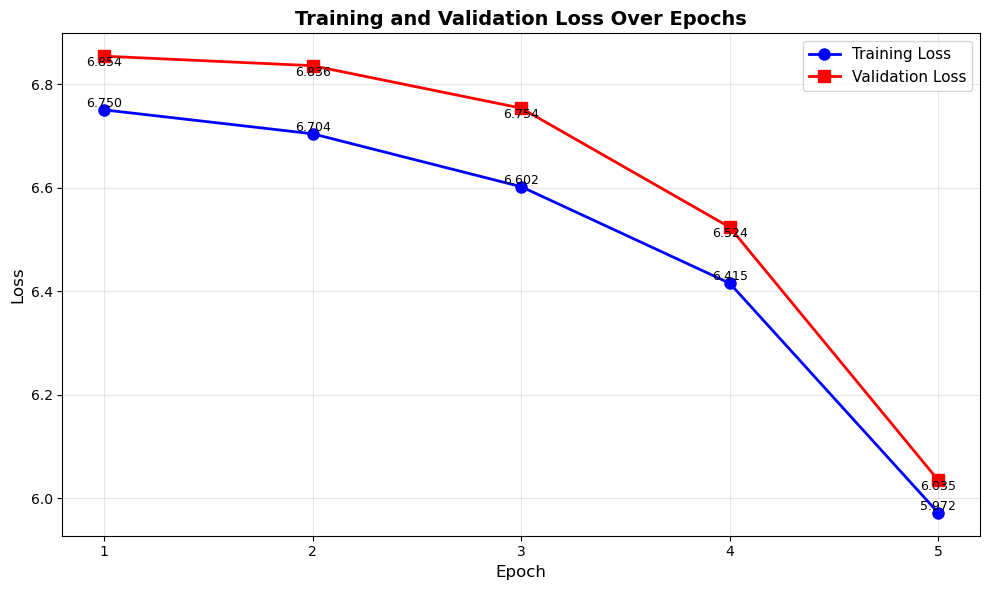

Training Complete!
Final Training Loss:   5.9718
Final Validation Loss: 6.0348


In [21]:
# run the training
num_epochs = 5
train_losses, val_losses = train_model(
    model_postln,
    train_dataloader,
    val_dataloader,
    criterion,
    optimizer,
    scheduler,
    device,
    num_epochs=num_epochs
)
plot_losses(train_losses, val_losses, num_epochs)

In [22]:
optimizer_preln = create_adamw_optimizer(model_preln, learning_rate=5e-5, weight_decay=1e-4)  # 5e-5 instead of 1e-4
scheduler_preln = TransformerScheduler(optimizer_preln, d_model=64, warmup_steps=100)

print("Pre-LN model training setup complete!")

Pre-LN model training setup complete!


Training Pre-LN model for 5 epochs...
Starting training for 5 epochs
Device: cuda:1
Epoch 1/5


Validation Epoch 1: 100%|██████████| 250/250 [00:01<00:00, 146.38it/s]


Epoch 1 Summary:
Train Loss: 5.3765
Val Loss: 5.3641
Epoch 2/5


Validation Epoch 2: 100%|██████████| 250/250 [00:01<00:00, 147.57it/s]


Epoch 2 Summary:
Train Loss: 4.7505
Val Loss: 5.2587
Epoch 3/5


Validation Epoch 3: 100%|██████████| 250/250 [00:01<00:00, 126.13it/s]


Epoch 3 Summary:
Train Loss: 4.5920
Val Loss: 5.2006
Epoch 4/5


Validation Epoch 4: 100%|██████████| 250/250 [00:01<00:00, 169.28it/s]


Epoch 4 Summary:
Train Loss: 4.4974
Val Loss: 5.1701
Epoch 5/5


Validation Epoch 5: 100%|██████████| 250/250 [00:01<00:00, 133.27it/s]


Epoch 5 Summary:
Train Loss: 4.4308
Val Loss: 5.1702


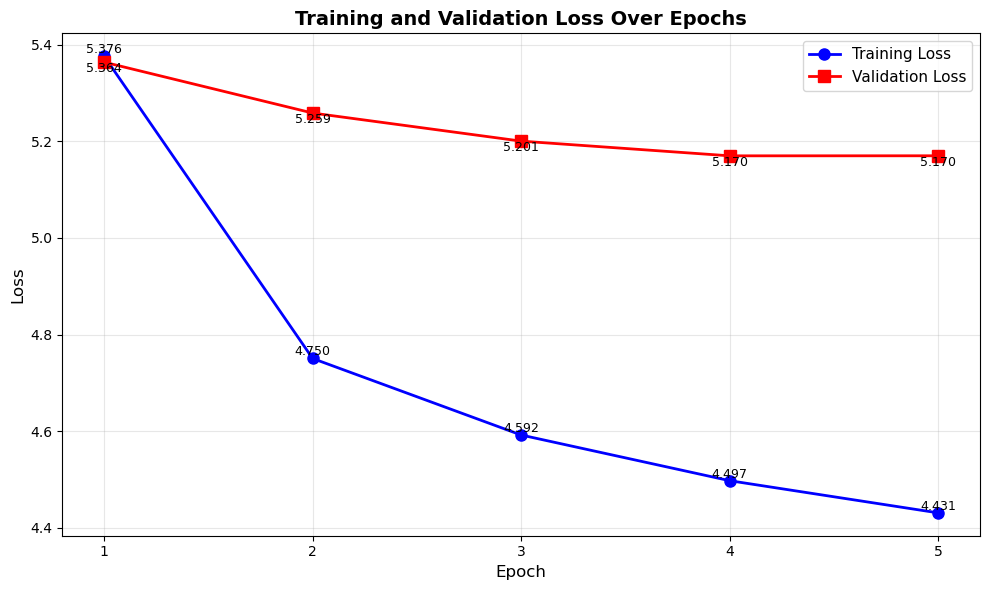

Training Complete!
Final Training Loss:   4.4308
Final Validation Loss: 5.1702


In [23]:
# Train the Pre-LN model
print("Training Pre-LN model for 5 epochs...")

num_epochs_preln = 5
train_losses_preln, val_losses_preln = train_model(
    model_preln,
    train_dataloader,
    val_dataloader,
    criterion,
    optimizer_preln,
    scheduler_preln,
    device,
    num_epochs=num_epochs_preln
)
plot_losses(train_losses_preln, val_losses_preln, num_epochs_preln)


In [24]:
from run.translate import translate_sentence

print("TESTING PRE-LN MODEL GENERATION")

test_sources = [
    "28-jähriger Koch in San Francisco Mall tot aufgefunden",
    "Hallo Welt",
    "Dies ist ein Test"
]

config_test = {
    "data":
        {
            "max_src_len": 32
        },
    "generation": 
        {
            "max_length": 32
        }
}

for src_text in test_sources:
    translation = translate_sentence(
        model_preln,
        tokenizer,
        src_text,
        device=device,
        config=config_test
    )

    print(f"\nSource: {src_text}")
    print(f"Translation: {translation}")

    # Check for repetition
    words = translation.split()
    unique = len(set(words))
    total = len(words)
    if unique < total * 0.5:
        print(f"Still repetitive: {unique}/{total} unique words")
    else:
        print(f"Better: {unique}/{total} unique words")

/home/amilitello/miniconda3/envs/transformer/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


TESTING PRE-LN MODEL GENERATION

Source: 28-jähriger Koch in San Francisco Mall tot aufgefunden
Translation: the hotel is located in the heart of the hotel .
Better: 8/11 unique words

Source: Hallo Welt
Translation: the hotel is located in the heart of the hotel .
Better: 8/11 unique words

Source: Dies ist ein Test
Translation: the european union is not in the european union .
Better: 7/10 unique words


### Practical 10
1. Implement the autoregressive generation procedure described above using your transformer mode(Using greedy decoding, remember to add a maximum length to the generation procedure to prevent infinite generation.)
2. Generate translations for the test set (or a subset of the test set) of WMT17 German-English.
3. Evaluate the BLEU score of your model on the test set (or a subset of the test set) of WMT17 German-English.
4. Evaluate some of the translations generated by your model. Do they make sense? What are some of the errors made by your model?

In [25]:
from translate import evaluate_bleu 

In [26]:
with open("../data/cleaned_wmt17_de_en_split_test.json", "r", encoding="utf-8") as f:
    test_data = json.load(f)

In [27]:
num_test_samples = 200
test_data_samples = test_data[:num_test_samples]

print(f"Total test samples available: {len(test_data)}")
print(f"Using {len(test_data_samples)} samples for evaluation")

Total test samples available: 2761
Using 200 samples for evaluation


In [28]:
src_sentence = test_data_samples[4]['src']
    
generated_translation = translate_sentence(
    model_preln,
    tokenizer,
    src_sentence,
    device=device,
    config=config_test
)

print(f"Source Sentence: {src_sentence}")
print(f"Generated Translation: {generated_translation}")

Source Sentence: Das San Francisco Police Department sagte, dass der Tod als Mord eingestuft wurde und die Ermittlungen am Laufen sind.
Generated Translation: the new macquis a , the most of the sy of the world s , and the world s , and the world s , and the


In [29]:
result = evaluate_bleu(
    model_preln,
    test_data_samples,
    tokenizer,
    device,
    config_test
)

Generating translations for 200 samples...
Progress: 10/200
Progress: 20/200
Progress: 30/200
Progress: 40/200
Progress: 50/200
Progress: 60/200
Progress: 70/200
Progress: 80/200
Progress: 90/200
Progress: 100/200
Progress: 110/200
Progress: 120/200
Progress: 130/200
Progress: 140/200
Progress: 150/200
Progress: 160/200
Progress: 170/200
Progress: 180/200
Progress: 190/200
Progress: 200/200


In [30]:
# print BLEU score and show 5 example translations
print(f"BLEU Score on Test Set: {result['bleu_score']:.2f}")

print("Example Translations:")
for i in range(5):
    print(f"Source: {result['source_texts'][i]}")
    print(f"Target: {result['references'][i]}")
    print(f"Predicted: {result['predictions'][i]}")

BLEU Score on Test Set: 0.00
Example Translations:
Source: 28-jähriger Koch in San Francisco Mall tot aufgefunden
Target: 28-Year-Old Chef Found Dead at San Francisco Mall
Predicted: the hotel is located in the heart of the hotel .
Source: Ein 28-jähriger Koch, der vor kurzem nach San Francisco gezogen ist, wurde im Treppenhaus eines örtlichen Einkaufzentrums tot aufgefunden.
Target: A 28-year-old chef who had recently moved to San Francisco was found dead in the stairwell of a local mall this week.
Predicted: the hotel is a very important to the most of the sy of the world , and the world , and the world , and the world , and the
Source: Der Bruder des Opfers sagte aus, dass er sich niemanden vorstellen kann, der ihm schaden wollen würde,  Endlich ging es bei ihm wieder bergauf. 
Target: But the victim s brother says he can t think of anyone who would want to hurt him, saying,  Things were finally going well for him. 
Predicted: the european union has been taken by the european union 

### Analysis of layer by layer std and mean
1. During training, record the mean and standard deviation of the activations at each layer of your transformer model (both before and after layer normalization).
2. Plot the mean and standard deviation of the activations at each layer as a function of training time.

In [35]:
def analyze_decoder_layers(model, src_ids, tgt_ids, src_mask, tgt_mask, device):
    model.eval()
    
    with torch.no_grad():
        memory = model.encode(src_ids, src_mask=src_mask)
        
        x = model.embedding(tgt_ids) * (model.d_model ** 0.5)
        x = model.positional_encoding(x)
        
        stats = []
        stats.append({
            'layer': 'Embedding',
            'mean': x.mean().item(),
            'std': x.std().item(),
            'max': x.abs().max().item()
        })
        
        for i, layer in enumerate(model.decoder_layers):
            x = layer(x, memory, encoder_attention_mask=src_mask, attention_mask=tgt_mask)
            stats.append({
                'layer': f'Layer {i+1}',
                'mean': x.mean().item(),
                'std': x.std().item(),
                'max': x.abs().max().item()
            })
    
    return stats

In [36]:
import numpy as np

src_text = "Ein 28-jähriger Koch"
src_ids = tokenizer.encode_src(src_text, max_length=32).unsqueeze(0).to(device)
src_mask = (src_ids != tokenizer.pad_id)

tgt_ids = torch.tensor([[tokenizer.bos_id]], dtype=torch.long).to(device)
tgt_mask = (tgt_ids != tokenizer.pad_id)

stats_postln = analyze_decoder_layers(model_postln, src_ids, tgt_ids, src_mask, tgt_mask, device)
stats_preln = analyze_decoder_layers(model_preln, src_ids, tgt_ids, src_mask, tgt_mask, device)

print("Post-LN Activation Statistics")
print(f"{'Layer':<15} {'Mean':>10} {'Std':>10} {'Max':>10}")
print("-" * 48)
for s in stats_postln:
    print(f"{s['layer']:<15} {s['mean']:>10.4f} {s['std']:>10.4f} {s['max']:>10.2f}")

print("\nPre-LN Activation Statistics")
print(f"{'Layer':<15} {'Mean':>10} {'Std':>10} {'Max':>10}")
print("-" * 48)
for s in stats_preln:
    print(f"{s['layer']:<15} {s['mean']:>10.4f} {s['std']:>10.4f} {s['max']:>10.2f}")


Post-LN Activation Statistics
Layer                 Mean        Std        Max
------------------------------------------------
Embedding          -0.1419     8.0679      23.44
Layer 1             0.0149     0.8528       2.50
Layer 2            -0.0081     0.5370       2.19

Pre-LN Activation Statistics
Layer                 Mean        Std        Max
------------------------------------------------
Embedding           0.4872     8.9169      21.21
Layer 1             0.7927    13.9519      50.95
Layer 2             0.7276    18.5589      75.90


In [37]:
layers = [s['layer'] for s in stats_postln]
layers_idx = np.arange(len(layers))

stds_postln = np.array([s['std'] for s in stats_postln])
stds_preln = np.array([s['std'] for s in stats_preln])
maxs_postln = np.array([s['max'] for s in stats_postln])
maxs_preln = np.array([s['max'] for s in stats_preln])

In [40]:
save_dir = "../figures/experiments/std_analysis/"
os.makedirs(save_dir, exist_ok=True)

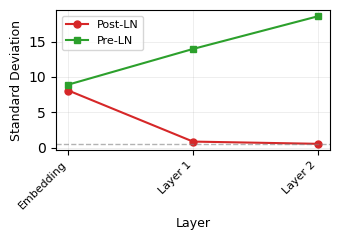

In [41]:
plt.figure(figsize=(3.5, 2.5))

plt.plot(layers_idx, stds_postln, marker='o', label='Post-LN', 
         linewidth=1.5, markersize=5, color='#d62728')
plt.plot(layers_idx, stds_preln, marker='s', label='Pre-LN', 
         linewidth=1.5, markersize=5, color='#2ca02c')
plt.axhline(0.5, color='gray', linestyle='--', linewidth=1, alpha=0.6)

plt.xticks(layers_idx, layers, rotation=45, ha='right', fontsize=8)
plt.ylabel('Standard Deviation', fontsize=9)
plt.xlabel('Layer', fontsize=9)
plt.legend(fontsize=8, loc='best', frameon=True)
plt.grid(True, alpha=0.3, linewidth=0.5)
plt.tight_layout()
plt.savefig(save_dir +'/decoder_layer_std_comparison.png', dpi=300)
plt.show()